# Sentiment Analysis and Topic Modelling on Twitter Dataset

The task chose for this project is sentiment analysis on a collection of 1.6*10e6 randomly sampled tweets. The dataset contains information about the text, the date, the username and of course about the correspondant label.

In order to tackle the problem, I use three different architectures:
- a regression model;
- a dense connected feed forward model
- a feed forward network with an embedding and a self attention layer.

Before proceding, data is cleaned and formatted.

I feed feature vectors to the regression model and the first neural architecture, whereas for the second model sentences are embedded using a pre-trained model, nalmely GloVe.

Results are evaluated usign precisio-recall curves to select the best threshold for discrimination of data. A classification report and a confusion matrix are also provided for each model.

Finally, topics are estracted using Latent Dirichlet Allocation and each sentence is labeled with a topic using GloVe embeddings.

#Installing and importing Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib as plt
import re
import nltk
import zipfile
import os
import tensorflow as tf
import numpy as np

from nltk.tokenize import wordpunct_tokenize
from numpy import argmax

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

from keras.models import Sequential
from keras import layers



from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


In [2]:
#The notebook is thought to be run in Google Colab, thus the Drive folder is mounted.

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive



Importing the dataset and loading it into a Pandas DataFrame

In [3]:
#The dataset I'm using in this project comes from Kaggle. For the scope of this project it was downloaded and stored in /gdrive/MyDrive/TextMining/ under the name of Twitter_SA.zip


file_path = '/gdrive/MyDrive/TextMining/Twitter_SA.zip'
encoding = "ISO-8859-1"
column_names = ["labels", "ids", "date", "dunno", "user", "text"]
compression = 'zip'


df = pd.read_csv(file_path, compression = compression, names = column_names, encoding = encoding, sep=',', quotechar='"')

In [4]:
# As a first step, we give a look to our data. It is composed of 6 columns, containing information like the text and the associated label, but also some additional 
# information about the date, the id and the user.

entries = df.shape[0]
print('\nThe dataset has a raw total of {} entries'.format(entries))

df.head(4)


The dataset has a raw total of 1600000 entries


,labels,ids,date,dunno,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire


#Pre-processing

In [5]:
# For the scope of this project we will focus only on text data and the correspondant labels, thus we drop superfluous columns.


to_drop = ['ids', 'date', 'dunno', 'user']

df.drop( to_drop, inplace=True, axis=1)

In [10]:
df.head()

,labels,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
# For the sake of error analysis, we first have to understand how our labels are distributed. In this case, they are equally distributed among the two classes.
# Data results equally distributed among negative and positive class.

df['labels'].value_counts()

0    800000
4    800000
Name: labels, dtype: int64

In [7]:
# As positive labels are indicated using a 4, we map them to 1 in order to have a more manageble dataset for the classification.

df['labels'] = df['labels'].apply(lambda x: 1 if x == 4 else 0)

In [8]:
# Checking that everything is ok with the mapping.

df['labels'].value_counts()

0    800000
1    800000
Name: labels, dtype: int64

In [9]:
# Checking for NaN values among text entries. Results that there are no NaN values.

df['text'].isnull().values.any()

False

Performing some basic text processing to get rid of special symbols, to lowercase and to expand contractions in order to gather as information as possible during training phase of the NNs.

In [10]:
# Defining a function for cleaning. On this step also usernames tags and urls are removed.

def clean(text):

  # I use regex to specify charaters and compbinations of characters that we want to remove. 
  to_remove = r"(@[^\s]+|@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?|"

  # I also lowercase the text and remove spaces at the beginning and at the end of sentences.
  text = re.sub (to_remove , "", str(text).lower()).strip()

  # Contractions could also be expanded using Contractions.contractions, but it takes an excessive amount of time and I decided to not use it for the moment.
  # text = contractions.fix(text)

  return text


# I apply the clean function to each entry of the df['text'] column. 
df['text'] = df['text'].apply(lambda text: clean(text))


In [16]:
df.head()

,labels,text
0,0,awww thats a bummer you shoulda got david car...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i her...


In [11]:
# I extract sentences and labels in order to procede to split the dataset into train and test sets.

sentences = df['text'].values
labels = df['labels'].values

sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.25, random_state=42)

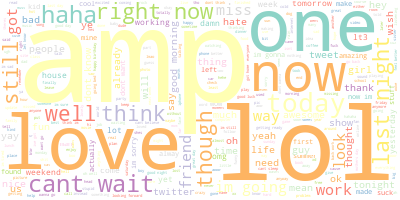

In [18]:
# In order to have a better sense of the words that make up our corpus, I display a wordcloud

from wordcloud import WordCloud


joint_tweets = ','.join(sentences)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, colormap = 'Set3')
wordcloud.generate(joint_tweets)
wordcloud.to_image()

#Preparing for Baseline model (regression)

In [19]:
df.head()

,labels,text
0,0,awww thats a bummer you shoulda got david car...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i her...


In [12]:
# I use the sklearn.feature_extraction.text.CountVectorizer method to create a vocabulary 
# out of the corpus and use it to build our feature vectors. The featue vectors, in this case
# will be sparse ones, with dimensions correspondant to the size of the vocabulary and a 1
# in correspondance of and occuring word. This is a Bag of Words model, still I don't take 
# into account the order of the words, rather just their occurence.


# I set a threshold to exclude non frequent words. Words with frequency below the min_df
# threshold will not be considered in building the vocabulary.
min_df = 0 #10e-6

# I procede to set the language in order to remove stopwords.
stop_words ='english'

# I build the vocabulary on the train data, in order to maintain generality and independence
# towards the test set, namely, as the test set could be any one, it doesn't make sense to 
# use it to build our vocabulary.
vectorizerr = CountVectorizer(min_df = min_df, stop_words = stop_words)
vectorizerr.fit(sentences_train)

# I procede to transform sentences into the feature vector representation. 
x_train = vectorizerr.transform(sentences_train)
x_test = vectorizerr.transform(sentences_test)

In [21]:
# The vocabulary has almost 360k unique words, which is a lot given that modern english has
# 170k words in current use, of which just 40k are of daily use. This could be explained by
# the fact that on twitter there's an extensive use of gergon, which can be really coloured 
# diverse and personal, also the possible typos and contractions have to be taken into account.
# For the moment let's see if from such a representation of data we can still train an
# effective model.

vocabulary = vectorizerr.vocabulary_
print('The so build vocabulary has {} unique words'.format(len(vocabulary.keys())))

The so build vocabulary has 361997 unique words


In [22]:
# In this cell the scaling of the data is defined. This is done in an attempt to 
# improve Logistic Regression performances by scaling data values on a given range.
# The attempt resulted in worst results wrt the not scaled version, although the model
# does not converge, thus I just let a commented version for the record.


#from sklearn import preprocessing

#scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
#x_scaled = scaler.transform(x_train)

In [23]:
# I defining a base line model using logistic regression. Saga is used as a solver 
# and max_iter is set to 300 to improve accuracy. Althoug the model does not converge, 
# despite several attempts with different solvers, optimizers and to scale data, 
# it still reaches 0.78 accuracy, which is not bad.

from sklearn.linear_model import LogisticRegression
 
classifier = LogisticRegression(max_iter = 300, solver = 'saga')
classifier.fit(x_train, labels_train)
 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(max_iter=300, solver='saga')

              precision    recall  f1-score   support

           0       0.79      0.75      0.77    199581
           1       0.76      0.80      0.78    200419

    accuracy                           0.78    400000
   macro avg       0.78      0.78      0.78    400000
weighted avg       0.78      0.78      0.78    400000



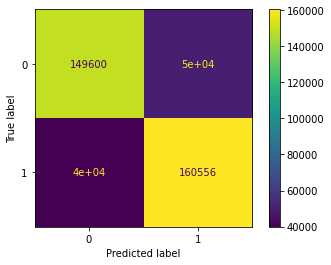

In [24]:
# I print the classification report and the confusion matrix to make sense of the results.


predicted_labels_rm = classifier.predict(x_test)

print(classification_report(labels_test, predicted_labels_rm))
ConfusionMatrixDisplay.from_predictions(labels_test, predicted_labels_rm)

#Improvin Baseline using NNs

In [12]:
# First thing, I define a function to find best threshold and best f1-score based on precision-recall curves.

def best_threshold(true_values, predicted_values):

  #calculate precision, recall and thresholds arrays using precision_recall_curve()
  precision, recall, thresholds = precision_recall_curve(true_values, predicted_values)

  #build an array of f1-scores calculated using precision and recall
  fscore = (2 * precision * recall) / (precision + recall)

  # find the best threshold as the threshold that maximizes f-1 score
  ix = argmax(fscore)
  best = thresholds[ix]
  print('Best Threshold={}'.format(thresholds[ix]))

  return best

In [15]:
import keras

x_train.shape[1]
keras.backend.clear_session()

In [28]:
x_train.shape[1]

361997

In [29]:
# I now procede to define a basic NN architecture for processing the feature vectors.
from keras.layers import Dropout, MultiHeadAttention

# First I set the input dimension for the model.
input_dim = x_train.shape[1]  

# I set the architecture of the model using the keras functional API
input_layer = Input(shape=(input_dim))
layer_1 = Dense(10, activation = 'relu')(input_layer)
layer_2 = Dropout(0.3)(layer_1)
output_layer= Dense(1, activation = 'sigmoid')(layer_2)

model_1 = Model(inputs = input_layer, outputs = output_layer)

# Then I compile the model and display a very brief summary.
model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy')
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 361997)]          0         
                                                                 
 dense (Dense)               (None, 10)                3619980   
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,619,991
Trainable params: 3,619,991
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model_1_fit = model_1.fit(x_train, labels_train, epochs=5, verbose=False, batch_size=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


Best Threshold=0.3921452462673187
              precision    recall  f1-score   support

           0       0.82      0.69      0.75    199581
           1       0.73      0.85      0.79    200419

    accuracy                           0.77    400000
   macro avg       0.78      0.77      0.77    400000
weighted avg       0.78      0.77      0.77    400000



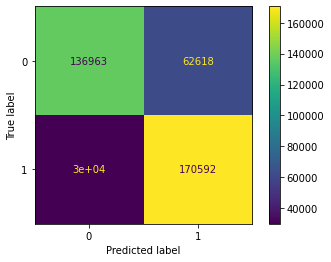

In [31]:
# As the model provides the results as probabilities in the range [0,1], I select a threshold for rounding using a
# custom algorithm based on precision-recall curves and f1 score.
predicted_values = model_1.predict(x_test)
best = best_threshold(labels_test, predicted_values)

# One the threshold is selected, labels are rounded accordingly.
predicted_values_best_1 = [1 if i > best else 0 for i in predicted_values]


# As a final step, we print the classification report, along with the confusion matrix.
print(classification_report(labels_test, predicted_values_best_1))
ConfusionMatrixDisplay.from_predictions(labels_test, predicted_values_best_1)

#Further improving through the use of GloVe embeddings and self-attention

From now on lets try to use GloVe embeddings to bettet capture the meaning of each world.

In [13]:
# To prepare my data for the embedding procedure, I first tokenize each tweet.


from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(sentences_train)

x_train = tokenizer.texts_to_sequences(sentences_train)
x_test = tokenizer.texts_to_sequences(sentences_test)


vocab_size = len(tokenizer.word_index) + 1  

In [33]:
print(vocab_size)
print(sentences_train[2])
print(x_train[2])

362345
ight i let they lil white boy know hahaha
[15597, 1, 229, 87, 661, 837, 525, 57, 393]


In [14]:
import numpy as np
import gensim.downloader as gloader

glove_model = gloader.load('glove-wiki-gigaword-300')


# I create a custom function to build the embedding matrix on the corpus that I'm using.              
def create_embedding_matrix(glove_model, embedding_dimension, word2idx):

  vocabulary_size = len(word2idx) + 1
  embedding_matrix = np.zeros((vocabulary_size, embedding_dimension), dtype = np.float32) 
  for word, idx in word2idx.items():
    try:
      embedding_vector = glove_model[word]
    except(KeyError, TypeError):
      # Out of vovabulary words are embedded using a vector sampled from a random uniform distribution.
      embedding_vector = np.random.uniform(low = -0.1, high = 0.1, size = embedding_dimension)
    embedding_matrix[idx] = embedding_vector
  return embedding_matrix

[==================================================] 100.0% 376.1/376.1MB downloaded


In [15]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix(glove_model, embedding_dim, tokenizer.word_index)

In [36]:
# In order to feed data with a coherent lenght to NN, I procede to pad.

from keras_preprocessing.sequence import pad_sequences

# I select the maxlen in an empirical way, i.e. 
maxlen = 40

x_train = pad_sequences(x_train, padding = 'post', maxlen = maxlen)
x_test = pad_sequences(x_test, padding = 'post', maxlen = maxlen)

In [40]:
import keras

keras.backend.clear_session()

In [41]:
input_dim = x_train.shape[1] 

# I now procede to define a basic NN architecture for processing the feature vectors.
from keras.layers import Dropout, MultiHeadAttention, Embedding, GlobalAveragePooling1D, Bidirectional, LSTM

# First I set the input dimension for the model.
input_dim = x_train.shape[1]  

# I set the architecture of the model using the keras functional API
input_layer = Input(shape=(input_dim,))
embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length = maxlen, mask_zero = True)(input_layer)

#lstm_layer = Bidirectional(LSTM(64,dropout=0.2))(embedding)
attention = MultiHeadAttention(8,16)(query = embedding, value = embedding)
pooling = GlobalAveragePooling1D()(attention)
layer_1 = Dense(10, activation = 'relu')(pooling)
layer_2 = Dropout(0.5)(layer_1)
output_layer= Dense(1, activation = 'sigmoid')(layer_2)
model_2 = Model(inputs = input_layer, outputs = output_layer)

model_2.compile(optimizer = 'adam', loss = 'binary_crossentropy')
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 300)      108703500   ['input_1[0][0]']                
                                                                                                  
 multi_head_attention (MultiHea  (None, 40, 300)     154284      ['embedding[0][0]',              
 dAttention)                                                      'embedding[0][0]']              
                                                                                                  
 global_average_pooling1d (Glob  (None, 300)         0           ['multi_head_attention[0][0]'

In [42]:
model_2_fit = model_2.fit(x_train, labels_train, epochs=2, verbose=False, validation_split = 0.15, batch_size=50)


In [ ]:
raise Exception('ciao')

Best Threshold=0.4505065083503723
              precision    recall  f1-score   support

           0       0.83      0.76      0.79    199581
           1       0.78      0.84      0.81    200419

    accuracy                           0.80    400000
   macro avg       0.80      0.80      0.80    400000
weighted avg       0.80      0.80      0.80    400000



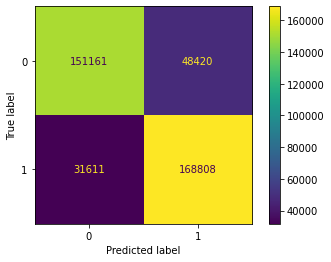

In [43]:
# As the model provides the results as probabilities in the range [0,1], I select a threshold for rounding using a
# custom algorithm based on precision-recall curves and f1 score.
predicted_values = model_2.predict(x_test)
best = best_threshold(labels_test, predicted_values)

# One the threshold is selected, labels are rounded accordingly.
predicted_values_best_2 = [1 if i > best else 0 for i in predicted_values]


# As a final step, we print the classification report, along with the confusion matrix.
print(classification_report(labels_test, predicted_values_best_2))
ConfusionMatrixDisplay.from_predictions(labels_test, predicted_values_best_2)

#Topic Modelling

My goal in this section is to extract a list of 10 topics from the corpus and assign them to each sentence according to cosine similarity.

To extract topics, I use Latend Dirichlet Allocation (LDA) a popular tool for topic modelling in NLP. Each topic is given as a set of 10 words with correspondant wheights, which tell how relevant a word is wrt to the topic. Then, for each topic I embedd the consitutent words using GloVe embeddings. Next, I perform the dot product of the embedded words and their wheigts to obtain and averege vector to be used for cosine similarity. I procede embedding the words of each sentence in our corpus and summing them to obtain also an average vector for each tweet. 

The final step is to assing a label to each tweet. To do so, I perform a cosine similarity between tweet embeddings and topic embeddings, selecting as labels the ones that have the highest score.

In [16]:
df_tk = df.copy(deep=True)

In [17]:
# The first step is to get rid of stopwords and short words that can't be really useful in defining a label and that could interfer with our results.

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# I get rid of stopwords and words shorter than 3 characters, then I tokenike each tweet using wordpunct_tokenize.
df_tk['text'] = df_tk['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words) if len(word)>3]))
df_tk['text'] = df_tk['text'].apply(wordpunct_tokenize)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
# In the previous experiments, stopwords were not deleted in order to better exploit semantical meaning in the self-attention layer of the last architecture. In this one I had deleted them because given their large
# frequency in text, they could be mistaken as topics. However, the embedding matrix I defined before was built on the sole fraction of data dedicated to training. Thus, I split again my dataset using the same
# random seed in order to have the same train set and use it for my topic modelling experiment.

# In order to use the embedding_matrix built on the train set, I split my data also in train set, using the same random_state in order to get the same tweets in this train set. 

sentences_un = df_tk['text'].values
sentences_tk, _, labels_tk, _ = train_test_split(sentences_un, labels, test_size=0.25, random_state=42)

In [19]:
# In order to make the LDA model work, I need to properly format my input data.

import gensim

# I build a dictionary to be used as id2word indexes in the LDA model.
dictionary = gensim.corpora.Dictionary(sentences_tk)

# I filter dictionry values to avoid non significant values.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# I finally build a bag of words out of the terms in the dictionary.
bow_corpus = bow_corpus = [dictionary.doc2bow(doc) for doc in sentences_tk]

In [20]:
# I train the genism LDA model in order to obtain a list of 10 topics.

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=4)

# I display the list of 10 words that make up each one of the ten topics, alonf with the respective wheigt.
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.047*"thanks" + 0.035*"much" + 0.035*"want" + 0.029*"come" + 0.029*"feel" + 0.023*"like" + 0.017*"please" + 0.016*"really" + 0.016*"love" + 0.016*"made"
Topic: 1 Word: 0.089*"cant" + 0.031*"wait" + 0.015*"sleep" + 0.014*"find" + 0.014*"watch" + 0.014*"song" + 0.012*"friday" + 0.010*"believe" + 0.009*"iphone" + 0.009*"game"
Topic: 2 Word: 0.044*"still" + 0.024*"today" + 0.020*"sick" + 0.019*"feeling" + 0.014*"bored" + 0.013*"need" + 0.012*"like" + 0.011*"really" + 0.011*"head" + 0.010*"nothing"
Topic: 3 Word: 0.099*"good" + 0.040*"night" + 0.040*"miss" + 0.037*"morning" + 0.025*"last" + 0.012*"like" + 0.012*"havent" + 0.011*"great" + 0.010*"time" + 0.009*"sounds"
Topic: 4 Word: 0.052*"work" + 0.032*"back" + 0.031*"going" + 0.027*"tomorrow" + 0.023*"time" + 0.020*"home" + 0.018*"today" + 0.017*"week" + 0.016*"school" + 0.015*"next"
Topic: 5 Word: 0.039*"wish" + 0.036*"would" + 0.030*"could" + 0.029*"love" + 0.012*"phone" + 0.010*"totally" + 0.009*"going" + 0.008*"time" + 

In [21]:
# In order to prepare data for cosine similarity, I first procede to build a dictionary containing the number of the topic along with the average vectore of the topic words embedded through GloVe embeddings.


# First I get the words ids using the word_index from the tokenizer employed in the previous section
idsss = [[tokenizer.word_index[j[0]] for j in lda_model.show_topic(i)] for i in range(10)]

# Then I embedd each word using the previously built embedding_matrix
emb = [[embedding_matrix[i] for i in j] for j in idsss]

# In order to give more importance to words that are wheigted more, I also extract the list of wheigts for the words of each topic
w =   [[j[1] for j in lda_model.show_topic(i)] for i in range(10)]

# Then I procede to get the average vector by performing the dot product between the embedded tokens and the correspondant wheights. Although this is not a proper average vector
# as it is not divided by the number of vectores involved in the sum, it is enough for the task of cosine similiarity that I'm going to perform later.
avg_embedded_topics = {i:np.dot(w[i], emb[i]) for i in range(10)}

In [22]:
# In order to perform cosine similarity I also need to embedd each one of the tokens that make up a tweet.

idx = [[tokenizer.word_index[j] for j in i] for i in sentences_tk]
embedded = [[embedding_matrix[i] for i in j] for j in idx]

# I use a for loop to sum all the vector embedding of each one of the tokens of the tweets

avg_embedded_tweet =[]

for i in range(len(embedded)):
  for j in range(len(embedded[i])):
    partial = np.zeros(300)
    partial = partial + embedded[i][j]
  avg_embedded_tweet.append(partial)

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial

# I use a custom function to perform cosine similarity and select the best topic.

def max_cosine(values, topics):
  scores = []
  for i in range(10):
    scores.append(spatial.distance.cosine(values, topics[i])%1)
  return scores.index(max(scores))

In [24]:
# Finally, I build a list of the best matching topic for each tweet, according to cosine similarity.

topics = [max_cosine(i, avg_embedded_topics) for i in avg_embedded_tweet]

In [29]:
len(topics)

1200000

In [31]:
topics[:10]

[9, 8, 7, 4, 1, 1, 6, 5, 1, 1]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


[]

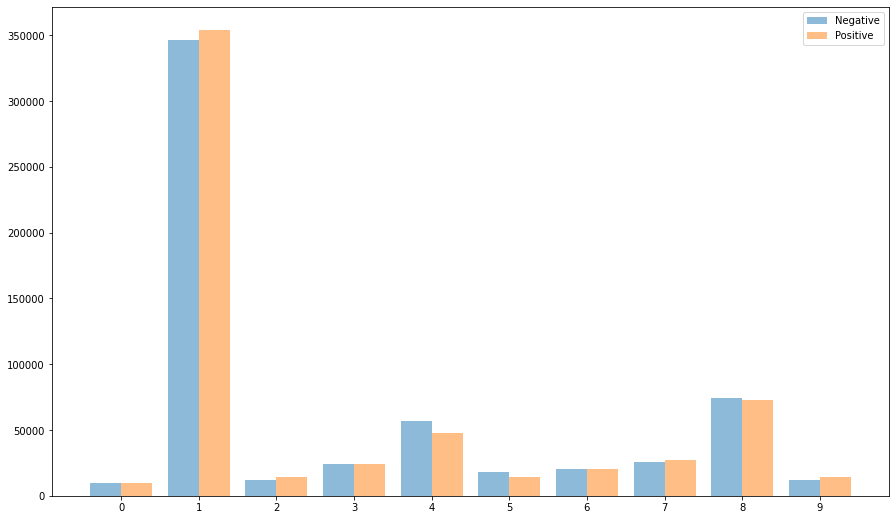

In [38]:
# As a final step, I plot a histogram of the number of positive and negative occurences for each assigned topic.


from matplotlib import pyplot


x = [topics[i] for i in range(len(topics)) if labels_tk[i]==0]
y = [topics[i] for i in range(len(topics)) if labels_tk[i]==1]



pyplot.figure(figsize=(15,9))
pyplot.hist([x,y], bins=np.arange(11)-0.5, alpha=0.5, label=['Negative','Positive'])
pyplot.xticks(np.arange(11))
pyplot.legend(loc='upper right')
pyplot.plot()